# Make datasets for cell locations

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt

## UniProt: GO cellular components

Who use as locations annoation?
- **Gene Ontology (cellular component)**:
    - more broad
    - no secreted
- **Subcellular location [CC]**:
    - more specific
    - how to deal wiht isoforms?
    - how to dela with protein that cna be in differt lcoations after some modifications?


In [13]:
df_cl = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/uniprotkb_reviewed_cellular_locations.tsv", sep="\t")

# Filter
df_cl = df_cl[
    (df_cl["Organism"] == "Homo sapiens (Human)") &
    (df_cl["Gene Names (primary)"].notna())
]
display(df_cl.head(3))

cl_names = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/unirpot_all_cell_locations_names.tsv", sep="\t")
STANDARD_LOCATIONS = set(cl_names['Name'].str.lower().str.strip())
print(STANDARD_LOCATIONS)
cl_names

,Entry,Reviewed,Gene Names (primary),Organism,Gene Ontology (cellular component),Subcellular location [CC],Length,Sequence
0,A0A087X1C5,reviewed,CYP2D7,Homo sapiens (Human),cytoplasm [GO:0005737]; intracellular membrane...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,515,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
1,A0A0B4J2F0,reviewed,PIGBOS1,Homo sapiens (Human),mitochondrial outer membrane [GO:0005741]; mit...,SUBCELLULAR LOCATION: Mitochondrion outer memb...,54,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...
2,A0A0C5B5G6,reviewed,MT-RNR1,Homo sapiens (Human),extracellular space [GO:0005615]; mitochondrio...,SUBCELLULAR LOCATION: Secreted {ECO:0000269|Pu...,16,MRWQEMGYIFYPRKLR


{'flagellum membrane', 'amyloplast membrane', 'host early endosome', 'cell surface', 'mitosome matrix', 'postsynapse', 'host synapse', 'mitosome intermembrane space', 'plastoglobule', 'postsynaptic cell membrane', 'phragmoplast', 'copii-coated vesicle membrane', 'host golgi apparatus membrane', 'cyanelle membrane', 'pml body', 'photoreceptor inner segment', 'etioplast membrane', 'cytoplasmic granule lumen', 'postsynaptic density membrane', 'peroxisome', 'postsynaptic recycling endosome', 'aleurone grain', 'host cytoplasmic vesicle', 'carboxysome', 'lipid-anchor', 'spore coat', 'host endoplasmic reticulum membrane', 'magnetosome membrane', 'plastid thylakoid', 'cytoplasmic vesicle lumen', 'endoplasmic reticulum lumen', 'desmosome', 'trans-golgi network membrane', 'mitochondrion nucleoid', 'host phagosome membrane', 'host cell projection', 'microsome membrane', 'protein storage vacuole membrane', 'intravirionic side', 'melanosome lumen', 'nucleoid', 'preautophagosomal structure', 'glycos

,Subcellular location ID,Name,Category,Gene Ontologies,Is a
0,SL-0476,A band,Cellular component,GO:0031672:A band,NaN
1,SL-0002,Acidocalcisome,Cellular component,GO:0020022:acidocalcisome,NaN
2,SL-0316,Acidocalcisome lumen,Cellular component,GO:0033985:acidocalcisome lumen,NaN
3,SL-0003,Acidocalcisome membrane,Cellular component,GO:0033102:acidocalcisome membrane,SL-0162; Membrane; LOCATION
4,SL-0007,Acrosome,Cellular component,GO:0001669:acrosomal vesicle,SL-0244; Secretory vesicle; LOCATION
...,...,...,...,...,...
559,SL-0549,Zymogen granule membrane,Cellular component,GO:0042589:zymogen granule membrane,SL-0245; Secretory vesicle membrane; LOCATION
560,SL-0067,cis-Golgi network,Cellular component,GO:0005801:cis-Golgi network,NaN
561,SL-0068,cis-Golgi network membrane,Cellular component,GO:0033106:cis-Golgi network membrane,SL-0134; Golgi apparatus membrane; LOCATION
562,SL-0266,trans-Golgi network,Cellular component,GO:0005802:trans-Golgi network,NaN


### Location: *Gene Ontology (cellular component)*

,Entry,Reviewed,Gene Names (primary),Organism,Gene Ontology (cellular component),Subcellular location [CC],Length,Sequence,GO-locations_list,GO-locations,GO_n_locations
0,A0A087X1C5,reviewed,CYP2D7,Homo sapiens (Human),cytoplasm [go:0005737]; intracellular membrane...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,515,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,"{cytoplasm, mitochondrion, membrane, intracell...","{cytoplasm, mitochondrion, membrane, intracell...",4
1,A0A0B4J2F0,reviewed,PIGBOS1,Homo sapiens (Human),mitochondrial outer membrane [go:0005741]; mit...,SUBCELLULAR LOCATION: Mitochondrion outer memb...,54,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,"{mitochondrion, mitochondrial outer membrane}","{mitochondrion, mitochondrial outer membrane}",2
2,A0A0C5B5G6,reviewed,MT-RNR1,Homo sapiens (Human),extracellular space [go:0005615]; mitochondrio...,SUBCELLULAR LOCATION: Secreted {ECO:0000269|Pu...,16,MRWQEMGYIFYPRKLR,"{mitochondrion, nucleus, extracellular space}","{mitochondrion, nucleus, extracellular space}",3
3,A0A0K2S4Q6,reviewed,CD300H,Homo sapiens (Human),extracellular region [go:0005576]; plasma memb...,SUBCELLULAR LOCATION: [Isoform 1]: Membrane {E...,201,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,"{plasma membrane, extracellular region}","{plasma membrane, extracellular region}",2


7143    Q5S007
Name: Entry, dtype: object

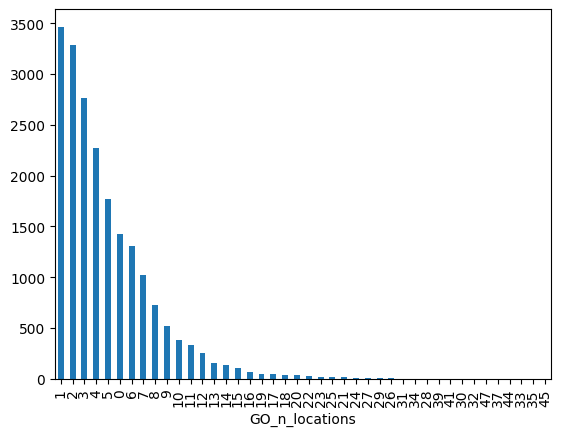

In [4]:
df_cl["Gene Ontology (cellular component)"] = df_cl["Gene Ontology (cellular component)"].fillna(value="")
df_cl["Gene Ontology (cellular component)"] = df_cl["Gene Ontology (cellular component)"].str.lower()


locations = []

for locs in df_cl["Gene Ontology (cellular component)"]:

    #print(locs)

    if locs == "":
        locations.append(set())
        continue

    locs = locs.split("; ")
    #print(locs)

    locs = [l.split(" [")[0] for l in locs]

    #print(locs)

    locations.append(set(locs))

df_cl["GO-locations_list"] = locations
df_cl["GO-locations"] = df_cl["GO-locations_list"].apply(set) 
df_cl["GO_n_locations"] = df_cl["GO-locations"].apply(len)

display(df_cl.head(4))

df_cl["GO_n_locations"].value_counts().plot(kind="bar", logy=False)

# high count protein?
df_cl[df_cl["GO_n_locations"] == 45].Entry

### Location: *Uniprot CC*

,Entry,Reviewed,Gene Names (primary),Organism,Gene Ontology (cellular component),Subcellular location [CC],Length,Sequence,GO-locations_list,GO-locations,GO_n_locations,Uniprot-locations_list,has_isoforms,Uniprot-locations,Uniprot_n_locations
0,A0A087X1C5,reviewed,CYP2D7,Homo sapiens (Human),cytoplasm [go:0005737]; intracellular membrane...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,515,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,"{cytoplasm, mitochondrion, membrane, intracell...","{cytoplasm, mitochondrion, membrane, intracell...",4,"[membrane, cytoplasm, mitochondrion]",False,"{cytoplasm, mitochondrion, membrane}",3
1,A0A0B4J2F0,reviewed,PIGBOS1,Homo sapiens (Human),mitochondrial outer membrane [go:0005741]; mit...,SUBCELLULAR LOCATION: Mitochondrion outer memb...,54,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,"{mitochondrion, mitochondrial outer membrane}","{mitochondrion, mitochondrial outer membrane}",2,[mitochondrion outer membrane],False,{mitochondrion outer membrane},1
2,A0A0C5B5G6,reviewed,MT-RNR1,Homo sapiens (Human),extracellular space [go:0005615]; mitochondrio...,SUBCELLULAR LOCATION: Secreted {ECO:0000269|Pu...,16,MRWQEMGYIFYPRKLR,"{mitochondrion, nucleus, extracellular space}","{mitochondrion, nucleus, extracellular space}",3,"[secreted, mitochondrion, nucleus]",False,"{mitochondrion, secreted, nucleus}",3
3,A0A0K2S4Q6,reviewed,CD300H,Homo sapiens (Human),extracellular region [go:0005576]; plasma memb...,SUBCELLULAR LOCATION: [Isoform 1]: Membrane {E...,201,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,"{plasma membrane, extracellular region}","{plasma membrane, extracellular region}",2,"[membrane, secreted]",True,"{secreted, membrane}",2


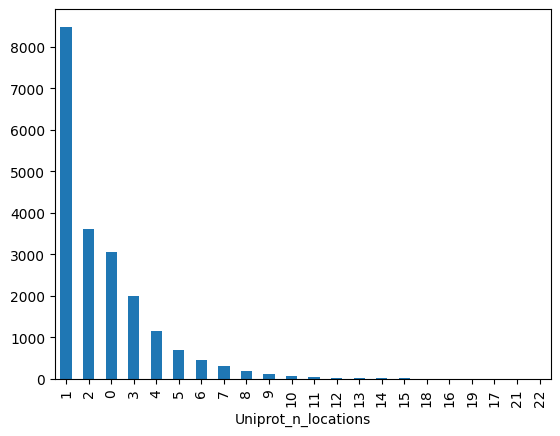

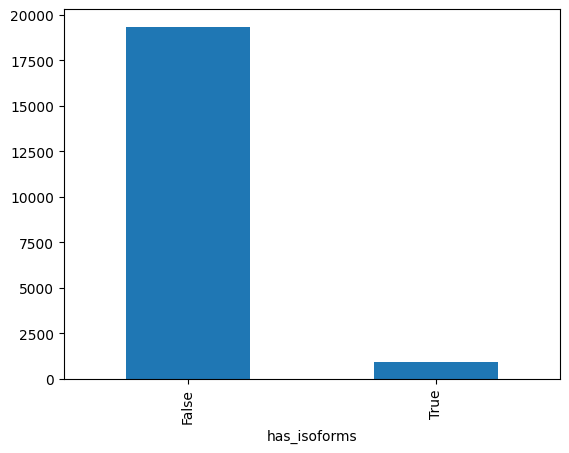

5558    Q06787
Name: Entry, dtype: object

In [5]:

def extract_locations(text):
    """
    Extract ALL subcellular locations from UniProt format.
    
    Returns:
        tuple: (locations_list, has_multiple_forms_bool)
    """
    locations = []
    has_multiple_forms = False
    
    # Check if text is empty
    if pd.isna(text) or not text.strip():
        return locations, has_multiple_forms
    
    # Check if contains subcellular location annotation
    if 'SUBCELLULAR LOCATION: ' not in text:
        return locations, has_multiple_forms
    
    # Remove evidence codes {}
    text = re.sub(r' \{[^}]+\}', '', text)
    
    # Split by 'SUBCELLULAR LOCATION: ' (first element is always empty)
    macros = text.split('SUBCELLULAR LOCATION: ')[1:]
    
    for macro in macros:
        # Remove notes (including those in parentheses)
        macro = macro.split(". Note")[0]
        macro = re.sub(r'\. Note=.*', '', macro, flags=re.IGNORECASE)
        
        # Remove isoform labels [Isoform X]:
        parts = re.split(r"\[[^\]]*\]:\s*", macro)
        macro = parts[-1]
        
        # If split happened, we have multiple forms
        if len(parts) > 1:
            has_multiple_forms = True
        
        # Split by period (different location statements)
        hierarchies = macro.split(". ")
        
        for h in hierarchies:
            # Remove qualifiers after ";"
            h = h.split(";")[0]
            
            # Split hierarchy by ","
            parts = h.split(", ")
            
            # Add to locations
            locations.extend(parts)
    
    # Clean up locations and filter against standard list
    cleaned_locations = []
    for loc in locations:
        
        loc = loc.strip().rstrip('.')
        
        # FILTER: Only keep if it matches a standard location
        if STANDARD_LOCATIONS and loc.lower() not in STANDARD_LOCATIONS:
            continue
        
        cleaned_locations.append(loc.lower())
    
    return cleaned_locations, has_multiple_forms



df_cl[['Uniprot-locations_list', 'has_isoforms']] = df_cl['Subcellular location [CC]'].apply(
    lambda x: pd.Series(extract_locations(x))
)

df_cl['Uniprot-locations'] = df_cl['Uniprot-locations_list'].apply(set)
df_cl['Uniprot_n_locations'] = df_cl['Uniprot-locations'].apply(len)


display(df_cl.head(4))

df_cl["Uniprot_n_locations"].value_counts().plot(kind="bar", logy=False); plt.show()
df_cl["has_isoforms"].value_counts().plot(kind="bar", logy=False); plt.show()


# high count protein?
df_cl[df_cl["Uniprot_n_locations"] == 22].Entry

In [6]:
# test
print(df_cl[df_cl.Entry=="O14788"]["Uniprot-locations_list"].to_list())

[['cell membrane', 'cell membrane', 'cytoplasm', 'secreted']]


In [7]:
# save processed df
df_cl.to_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/uniprotkb_reviewed_cellular_locations_formatted.csv", index=False)

## Create dataset Location

- Need to pass resulting csv to `02_makedataset.ipynb`
- Take also prot with multiple locations

- 02_make_dataset is based on gene, so we need to maitian them

### Choose location col to use

All locations:  245
{'cell tip', 'flagellum membrane', 'golgi apparatus', 'cell surface', 'mitochondrion', 'centriolar satellite', 'postsynapse', 'surface film', 'parasitophorous vacuole', 'cytolytic granule membrane', 'adherens junction', 'microvillus', 'phagosome', 'postsynaptic cell membrane', 'copii-coated vesicle membrane', 'multivesicular body lumen', 'late endosome', 'pml body', 'photoreceptor inner segment', 'cytoplasmic granule lumen', 'postsynaptic density membrane', 'focal adhesion', 'inflammasome', 'centrosome', 'lysosome', 'peroxisome', 'nucleoplasm', 'autolysosome', 'copi-coated vesicle', 'secretory vesicle', 'nucleus lamina', 'secretory vesicle lumen', 'acrosome inner membrane', 'vacuole membrane', 'spindle pole body', 'nucleus speckle', 'golgi apparatus lumen', 'endoplasmic reticulum', 'lateral cell membrane', 'cleavage furrow', 'peroxisome matrix', 'pseudopodium membrane', 'postsynaptic density', 'flagellum axoneme', 'clathrin-coated pit', 'cytoplasmic vesicle lumen', 

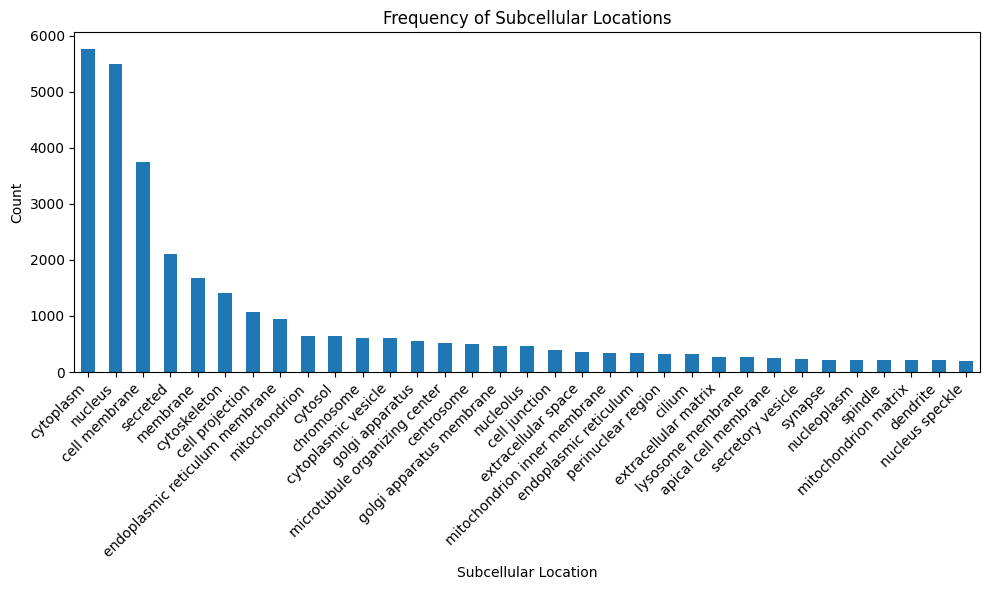

In [8]:
ANNOTATION_TYPE = "Uniprot-locations" # GO, Uniprot
MIN_PROTEIN_PER_LOCATION = 200

# All locations
all_locations = set().union(*df_cl[ANNOTATION_TYPE])
print("All locations: ", len(all_locations))
print(all_locations)

# How porteins per location
all_locations_list = [loc for locs in df_cl[ANNOTATION_TYPE] for loc in locs]
len(all_locations_list)
counts = pd.Series(all_locations_list).value_counts()
counts = counts[counts>=MIN_PROTEIN_PER_LOCATION]
allowed_locations = set(counts.index)
print("Allowed locations: ", len(allowed_locations))
print(allowed_locations)

plt.figure(figsize=(10, 6))
counts.plot(kind="bar")
plt.title("Frequency of Subcellular Locations")
plt.xlabel("Subcellular Location")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [9]:
LOCATION = "secreted"

df_location = df_cl[
    #(df["n_location"] == 1) &
    (df_cl[ANNOTATION_TYPE].apply(lambda x: len(set([LOCATION]).intersection(x)) != 0 )) 
    ].copy()

df_location = df_location[["Gene Names (primary)"]].rename(columns={"Gene Names (primary)": "gene"})
df_location["geneset_count"] = 1 # costant (sample with same probavility)
df_location["definitive_positive"] = 1

# if gene has more names, dupclate the row with doffer geens names
df_location["gene"] = df_location["gene"].str.split("; ")
df_location = df_location.explode("gene").reset_index(drop=True)

display(df_location)
df_location["definitive_positive"].value_counts()

,gene,geneset_count,definitive_positive
0,MT-RNR1,1,1
1,CD300H,1,1
2,IGLC7,1,1
3,ODAM,1,1
4,PXDNL,1,1
...,...,...,...
2122,MTRNR2L13,1,1
2123,MTRNR2L11,1,1
2124,SCPPPQ1,1,1
2125,RBAKDN,1,1


definitive_positive
1    2127
Name: count, dtype: int64

In [10]:
# Save
df_location.to_csv(f"/home/gdallagl/myworkdir/ESMSec/data/cell_location/{LOCATION}_{ANNOTATION_TYPE}_02_positive_proteins.csv", index=False)

In [11]:
stop

NameError: name 'stop' is not defined

# CD-CODE Cell condensates

In [ ]:
# Load Allowed proteins (reviewed unirpot)
uniprot = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/human_proteome.tsv", sep="\t")

# only reviewd
uniprot = uniprot[uniprot.Reviewed == "reviewed"]

# Rename
uniprot = uniprot[["Entry", "Sequence"]].rename(columns={"Entry": "protein", "Sequence": "sequence"})

uniprot

In [ ]:
# oad ocndesate locations
df = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/protein_in_condensates_CD-CODE.tsv", sep="\t")

# Only allowed proteins
df = df[df.uniprotkb_ac.isin(uniprot.protein.to_list())]

# Drop proteins in MULTIPLE locations
df = df.drop_duplicates(subset=["uniprotkb_ac"], keep=False)
display(df[df.duplicated(subset=["uniprotkb_ac"], keep=False)].sort_values(by="uniprotkb_ac")) # check for duoslaictes

# condenste with at least 100 proteins
allowed_condensates = df.condensate_name.value_counts()[df.condensate_name.value_counts() >= 50].index.to_list()
display(df.condensate_name.value_counts()[df.condensate_name.value_counts() >= 50])
print(allowed_condensates)

# Filter
df = df[(df.condensate_name.isin(allowed_condensates))]

display(df)


In [ ]:
#protein	sequence	label	set

condensate_to_int = {
    name: idx 
    for idx, name in enumerate(df['condensate_name'].unique())
}

df['label'] = df['condensate_name'].map(condensate_to_int)


df = df.rename(columns={"uniprotkb_ac": "protein"}).merge(uniprot)

df

In [ ]:
df_location.to_csv(f"/home/gdallagl/myworkdir/ESMSec/data/cell_location/{CONDENSATE}_02_positive_proteins.csv", index=False)

---

## Secreted Proteins (no multiple locations)

With csv, run 02_makedataset.ipynb

In [ ]:
df_secreted = df[
    #(df["n_location"] == 1) &
    (df["location"].apply(lambda x: len(set(["Secreted"]).intersection(x)) != 0 )) 
    ].copy()

df_secreted = df_secreted[["Entry", "Length", "location", "Gene Names (primary)", "n_location", "Sequence"]].rename(columns={"Entry": "protein", "Gene Names (primary)": "gene", "Sequence": "sequence"})
df_secreted["geneset_count"] = 1 # costant (sample with same probavility)
df_secreted["definitive_positive"] = df_secreted["n_location"].apply(lambda x: x == 1) # the False will be sondiered ambigues and thus removeed on the o2_makedataset scirpt

display(df_secreted)
df_secreted["definitive_positive"].value_counts()



,protein,Length,location,gene,n_location,sequence,geneset_count,definitive_positive
2,A0A0C5B5G6,16,"{Mitochondrion, Nucleus, Secreted}",MT-RNR1,3,MRWQEMGYIFYPRKLR,1,False
3,A0A0K2S4Q6,201,"{Secreted, Membrane}",CD300H,2,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,1,False
17,A0M8Q6,106,"{Cell membrane, Secreted}",IGLC7,2,GQPKAAPSVTLFPPSSEELQANKATLVCLVSDFNPGAVTVAWKADG...,1,False
28,A1E959,279,"{Cytoplasm, Nucleus, Secreted}",ODAM,3,MKIIILLGFLGATLSAPLIPQRLMSASNSNELLLNLNNGQLLPLQL...,1,False
30,A1KZ92,1463,"{Cell membrane, Cytoplasm, Secreted, Endoplasm...",PXDNL,4,MEPRLFCWTTLFLLAGWCLPGLPCPSRCLCFKSTVRCMHLMLDHIP...,1,False
...,...,...,...,...,...,...,...,...
20071,S4R3P1,24,"{Cytoplasm, Secreted}",MTRNR2L13,2,MDTQGFSCLLLLISEIDLSVKRRI,1,False
20072,S4R3Y5,24,"{Cytoplasm, Secreted}",MTRNR2L11,2,MATRGFSCLLLVISEIDLSVKRWV,1,False
20123,A0A411D538,79,{Secreted},SCPPPQ1,1,MKFLILAGLLSTATALPIPLEQYAESSSEQRFIFYPPQVPPFFPQV...,1,True
20135,A6NC62,81,{Secreted},RBAKDN,1,MWPPLLLLLLLLPAAPVPTAKAAPHPDANTQEGLQNLLQGVGAGGD...,1,True


definitive_positive
False    1139
True      970
Name: count, dtype: int64

In [ ]:
print(df_secreted[df_secreted["definitive_positive"] == True].protein.to_list())

['A8K2U0', 'O00175', 'O00187', 'O00292', 'O00300', 'O00339', 'O00585', 'O00622', 'O00626', 'O14594', 'O14625', 'O14791', 'O14793', 'O15041', 'O15123', 'O15130', 'O15204', 'O15232', 'O15263', 'O15444', 'O15467', 'O15520', 'O43240', 'O43320', 'O43827', 'O43854', 'O43897', 'O43915', 'O43927', 'O60258', 'O60383', 'O60565', 'O75093', 'O75094', 'O75462', 'O75556', 'O75610', 'O75629', 'O75636', 'O75888', 'O76061', 'O76076', 'O76093', 'O94813', 'O94907', 'O94919', 'O95388', 'O95390', 'O95393', 'O95399', 'O95407', 'O95428', 'O95445', 'O95460', 'O95715', 'O95750', 'O95813', 'O95965', 'O95968', 'O95972', 'O95998', 'O96009', 'P00450', 'P00709', 'P00738', 'P00739', 'P00740', 'P00742', 'P00746', 'P00747', 'P00748', 'P00749', 'P00995', 'P01011', 'P01019', 'P01023', 'P01033', 'P01034', 'P01036', 'P01037', 'P01127', 'P01148', 'P01178', 'P01185', 'P01189', 'P01213', 'P01215', 'P01222', 'P01225', 'P01229', 'P01236', 'P01241', 'P01242', 'P01258', 'P01266', 'P01270', 'P01275', 'P01282', 'P01286', 'P01298',

In [ ]:
df_secreted.to_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/secreted_01_positive_proteins.csv", index=False)

## Lysosome (no multiple locations)

With csv, run 02_makedataset.ipynb

In [ ]:
df_lyso = df[
    #(df["location"].apply(lambda x: len(set(["Lysosome lumen", "Lysosome membrane", "Lysosome"]).intersection(x)) != 0 )) &
    (df["location"].apply(lambda x: len(set(["Lysosome lumen", "Lysosome"]).intersection(x)) != 0 )) &
    (df["n_location"] == 1) 
    ]

df_lyso = df_lyso[["Entry", "Length", "location", "Gene Names (primary)", "n_location", "Sequence"]].rename(columns={"Entry": "protein", "Gene Names (primary)": "gene", "Sequence": "sequence"})
df_lyso["geneset_count"] = 1 # costant
df_lyso["definitive_positive"] = True # costant

print(df_lyso.shape)
df_lyso.sort_values("gene").head(10)



(40, 8)


,protein,Length,location,gene,n_location,sequence,geneset_count,definitive_positive
2714,P13686,325,{Lysosome},ACP5,1,MDMWTALLILQALLLPSLADGATPALRFVAVGDWGGVPNAPFHTAR...,1,True
3126,P20933,346,{Lysosome},AGA,1,MARKSNLPVLLVPFLLCQALVRCSSPLPLVVNTWPFKNATEAAWRA...,1,True
15020,P51689,593,{Lysosome},ARSD,1,MRSAARRGRAAPAARDSLPVLLFLCLLLKTCEPKTANAFKPNILLI...,1,True
10448,Q96EG1,525,{Lysosome},ARSG,1,MGWLFLKVLLAGVSFSGFLYPLVDFCISGKTRGQKPNFVIILADDM...,1,True
15107,Q01459,385,{Lysosome},CTBS,1,MSRPQLRRWRLVSSPPSGVPGLALLALLALLALRLAAGTDCPCPEP...,1,True
2538,P10619,480,{Lysosome},CTSA,1,MIRAAPPPLFLLLLLLLLLVSWASRGEAAPDQDEIQRLPGLAKQPS...,1,True
4617,P53634,463,{Lysosome},CTSC,1,MGAGPSLLLAALLLLLSGDGAVRCDTPANCTYLDLLGTWVFQVGSS...,1,True
13470,Q9UBX1,484,{Lysosome},CTSF,1,MAPWLQLLSLLGLLPGAVAAPAQPRAASFQAWGPPSPELLAPTRFA...,1,True
2393,P09668,335,{Lysosome},CTSH,1,MWATLPLLCAGAWLLGVPVCGAAELCVNSLEKFHFKSWMSKHRKTY...,1,True
4066,P43234,321,{Lysosome},CTSO,1,MDVRALPWLPWLLWLLCRGGGDADSRAPFTPTWPRSREREAAAFRE...,1,True


In [ ]:
df_lyso.to_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/lyso_01_positive_proteins.csv", index=False)

## Lyso Vs Secreted

NOOOOO need for 02_makeDataset.ipynb

In [ ]:
df_lyso.loc[:, "label"] = 1 # costant
df_secreted.loc[:, "label"] = 0 # costant

data = pd.concat([df_lyso, df_secreted])

# Remove ambigous from secretedS
data = data[data.definitive_positive == True]

data["geneset_count"] = 1 # costant

data

,protein,Length,location,gene,n_location,sequence,geneset_count,definitive_positive,label
190,O00115,360,{Lysosome},DNASE2,1,MIPLLLAALLCVPAGALTCYGDSGQPVDWFVVYKLPALRGSGEAAQ...,1,True,1
289,O00462,879,{Lysosome},MANBA,1,MRLHLLLLLALCGAGTTAAELSYSLRGNWSICNGNGSLELPGAVPG...,1,True,1
346,O00754,1011,{Lysosome},MAN2B1,1,MGAYARASGVCARGCLDSAGPWTMSRALRPPLPPLCFFLLLLAAAG...,1,True,1
1096,O60911,334,{Lysosome},CTSV,1,MNLSLVLAAFCLGIASAVPKFDQNLDTKWYQWKATHRRLYGANEEG...,1,True,1
2032,P04066,466,{Lysosome},FUCA1,1,MRAPGMRSRPAGPALLLLLLFLGAAESVRRAQPPRRYTPDWPSLDS...,1,True,1
...,...,...,...,...,...,...,...,...,...
20008,Q9H7B7,122,{Secreted},PKD1L1-AS1,1,MGFHFCIWIIFLLPPPCKKCLSPPTMNLRPPKSCGNVFYWVLVLNS...,1,True,0
20027,Q9NRI6,33,{Secreted},PYY2,1,MATVLLALLVYLGALVDAYPIKPEAPGEDAFLG,1,True,0
20123,A0A411D538,79,{Secreted},SCPPPQ1,1,MKFLILAGLLSTATALPIPLEQYAESSSEQRFIFYPPQVPPFFPQV...,1,True,0
20135,A6NC62,81,{Secreted},RBAKDN,1,MWPPLLLLLLLLPAAPVPTAKAAPHPDANTQEGLQNLLQGVGAGGD...,1,True,0


In [ ]:
from sklearn.model_selection import train_test_split

# Stratified split by label
train_clusters, temp_clusters = train_test_split(
    data,
    test_size=0.2,
    stratify=data['label'],
    random_state=42
)
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_clusters['label'],
    random_state=42
)

train_prots = train_clusters["protein"].to_list()
val_prots = val_clusters["protein"].to_list()
test_prots = test_clusters["protein"].to_list()

test_prots
data['set'] = ["train" if p in train_prots else "val" if p in val_prots else "test" for p in data["protein"]]
data.loc[data[data.set == "val"].index[1:], "set"] = "test"  # just to have more

# Check split distribution 
print(data.groupby('set')['label'].value_counts().unstack(fill_value=0)) 
display(data)


label    0   1
set           
test   194   7
train  776  32
val      0   1


,protein,Length,location,gene,n_location,sequence,geneset_count,definitive_positive,label,set
190,O00115,360,{Lysosome},DNASE2,1,MIPLLLAALLCVPAGALTCYGDSGQPVDWFVVYKLPALRGSGEAAQ...,1,True,1,train
289,O00462,879,{Lysosome},MANBA,1,MRLHLLLLLALCGAGTTAAELSYSLRGNWSICNGNGSLELPGAVPG...,1,True,1,train
346,O00754,1011,{Lysosome},MAN2B1,1,MGAYARASGVCARGCLDSAGPWTMSRALRPPLPPLCFFLLLLAAAG...,1,True,1,train
1096,O60911,334,{Lysosome},CTSV,1,MNLSLVLAAFCLGIASAVPKFDQNLDTKWYQWKATHRRLYGANEEG...,1,True,1,val
2032,P04066,466,{Lysosome},FUCA1,1,MRAPGMRSRPAGPALLLLLLFLGAAESVRRAQPPRRYTPDWPSLDS...,1,True,1,test
...,...,...,...,...,...,...,...,...,...,...
20008,Q9H7B7,122,{Secreted},PKD1L1-AS1,1,MGFHFCIWIIFLLPPPCKKCLSPPTMNLRPPKSCGNVFYWVLVLNS...,1,True,0,train
20027,Q9NRI6,33,{Secreted},PYY2,1,MATVLLALLVYLGALVDAYPIKPEAPGEDAFLG,1,True,0,test
20123,A0A411D538,79,{Secreted},SCPPPQ1,1,MKFLILAGLLSTATALPIPLEQYAESSSEQRFIFYPPQVPPFFPQV...,1,True,0,train
20135,A6NC62,81,{Secreted},RBAKDN,1,MWPPLLLLLLLLPAAPVPTAKAAPHPDANTQEGLQNLLQGVGAGGD...,1,True,0,train


In [ ]:
data.to_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/lyso-secreted_02_dataset.csv", index=False)

# CD-CODE Cell condensates (no multiple locations)

In [ ]:
# Load Allowed proteins (reviewed unirpot)
uniprot = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/human_proteome.tsv", sep="\t")

# only reviewd
uniprot = uniprot[uniprot.Reviewed == "reviewed"]

# Rename
uniprot = uniprot[["Entry", "Sequence"]].rename(columns={"Entry": "protein", "Sequence": "sequence"})

uniprot

,protein,sequence
0,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
1,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...
2,A0A0C5B5G6,MRWQEMGYIFYPRKLR
3,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...
4,A0A0U1RRE5,MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...
...,...,...
20400,Q9UI25,MEEMSYGENSGTHVGSFSCSPQPSQQMKVLFVGNSFLLTPVLHRQP...
20401,Q9UI54,MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...
20402,Q9UI72,MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...
20403,Q9Y3F1,MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...


In [ ]:
# oad ocndesate locations
df = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/protein_in_condensates_CD-CODE.tsv", sep="\t")

# Only allowed proteins
df = df[df.uniprotkb_ac.isin(uniprot.protein.to_list())]

# Drop proteins in MULTIPLE locations
df = df.drop_duplicates(subset=["uniprotkb_ac"], keep=False)
display(df[df.duplicated(subset=["uniprotkb_ac"], keep=False)].sort_values(by="uniprotkb_ac")) # check for duoslaictes

# condenste with at least 100 proteins
allowed_condensates = df.condensate_name.value_counts()[df.condensate_name.value_counts() >= 50].index.to_list()
display(df.condensate_name.value_counts()[df.condensate_name.value_counts() >= 50])
print(allowed_condensates)

# Filter
df = df[(df.condensate_name.isin(allowed_condensates))]

display(df)


,uniprotkb_ac,condensate_id,condensate_name


condensate_name
Presynaptic clusters and postsynaptic densities    886
Nucleolus                                          602
Centrosome                                         326
Stress granule                                     243
P-body                                              74
Nuclear speckle                                     71
PML body                                            66
Name: count, dtype: int64

['Presynaptic clusters and postsynaptic densities', 'Nucleolus', 'Centrosome', 'Stress granule', 'P-body', 'Nuclear speckle', 'PML body']


,uniprotkb_ac,condensate_id,condensate_name
1264,Q14164,B5B9A610,PML body
1265,P27694,B5B9A610,PML body
1266,P61956,B5B9A610,PML body
1268,P01023,B5B9A610,PML body
1270,P15408,B5B9A610,PML body
...,...,...,...
10358,P30837,91857CE7,Nucleolus
10359,P61313,91857CE7,Nucleolus
10476,Q32NC0,91857CE7,Nucleolus
10477,Q86VY4,91857CE7,Nucleolus


In [ ]:
#protein	sequence	label	set

condensate_to_int = {
    name: idx 
    for idx, name in enumerate(df['condensate_name'].unique())
}

df['label'] = df['condensate_name'].map(condensate_to_int)


df = df.rename(columns={"uniprotkb_ac": "protein"}).merge(uniprot)

df

,protein,condensate_id,condensate_name,label,sequence
0,Q14164,B5B9A610,PML body,0,MQSTANYLWHTDDLLGQGATASVYKARNKKSGELVAVKVFNTTSYL...
1,P27694,B5B9A610,PML body,0,MVGQLSEGAIAAIMQKGDTNIKPILQVINIRPITTGNSPPRYRLLM...
2,P61956,B5B9A610,PML body,0,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...
3,P01023,B5B9A610,PML body,0,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...
4,P15408,B5B9A610,PML body,0,MYQDYPGNFDTSSRGSSGSPAHAESYSSGGGGQQKFRVDMPGSGSA...
...,...,...,...,...,...
2263,P30837,91857CE7,Nucleolus,6,MLRFLAPRLLSLQGRTARYSSAAALPSPILNPDIPYNQLFINNEWQ...
2264,P61313,91857CE7,Nucleolus,6,MGAYKYIQELWRKKQSDVMRFLLRVRCWQYRQLSALHRAPRPTRPD...
2265,Q32NC0,91857CE7,Nucleolus,6,MRQKHYLEAAARGLHDSCPGQARYLLWAYTSSHDDKSTFEETCPYC...
2266,Q86VY4,91857CE7,Nucleolus,6,MSGRSRGRKSSRAKNRGKGRAKARVRPAPDDAPRDPDPSQYQSLGE...


In [ ]:
from sklearn.model_selection import train_test_split

# Stratified split by label
train_clusters, temp_clusters = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_clusters['label'],
    random_state=42
)

train_prots = train_clusters["protein"].to_list()
val_prots = val_clusters["protein"].to_list()
test_prots = test_clusters["protein"].to_list()

test_prots
df['set'] = ["train" if p in train_prots else "val" if p in val_prots else "test" for p in df["protein"]]
df.loc[df[df.set == "val"].index[1:], "set"] = "test"  # just to have more

# Check split distribution 
print(df.groupby('set')['label'].value_counts().unstack(fill_value=0)) 
display(df)


label   0   1    2   3    4    5    6
set                                  
test   12  14   65  15  177   49  121
train  53  57  261  59  709  194  481
val     1   0    0   0    0    0    0


,protein,condensate_id,condensate_name,label,sequence,set
0,Q14164,B5B9A610,PML body,0,MQSTANYLWHTDDLLGQGATASVYKARNKKSGELVAVKVFNTTSYL...,train
1,P27694,B5B9A610,PML body,0,MVGQLSEGAIAAIMQKGDTNIKPILQVINIRPITTGNSPPRYRLLM...,train
2,P61956,B5B9A610,PML body,0,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...,train
3,P01023,B5B9A610,PML body,0,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,train
4,P15408,B5B9A610,PML body,0,MYQDYPGNFDTSSRGSSGSPAHAESYSSGGGGQQKFRVDMPGSGSA...,train
...,...,...,...,...,...,...
2263,P30837,91857CE7,Nucleolus,6,MLRFLAPRLLSLQGRTARYSSAAALPSPILNPDIPYNQLFINNEWQ...,train
2264,P61313,91857CE7,Nucleolus,6,MGAYKYIQELWRKKQSDVMRFLLRVRCWQYRQLSALHRAPRPTRPD...,train
2265,Q32NC0,91857CE7,Nucleolus,6,MRQKHYLEAAARGLHDSCPGQARYLLWAYTSSHDDKSTFEETCPYC...,train
2266,Q86VY4,91857CE7,Nucleolus,6,MSGRSRGRKSSRAKNRGKGRAKARVRPAPDDAPRDPDPSQYQSLGE...,train


In [ ]:
df[df.duplicated(subset=["protein"], keep=False)].sort_values(by="protein")

,protein,condensate_id,condensate_name,label,sequence,set


In [ ]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/condensate_02_dataset.csv", index=False)